In [10]:
# ===============================================
# Clean → Encode → Classify (KNN) — Simplified
# ===============================================
# Dataset: Kaggle "Mushroom Classification"
# Expected file: ./mushrooms.csv

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer  # used ONCE as an example
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
pip install os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
ERROR: No matching distribution found for os
Note: you may need to restart the kernel to use updated packages.


In [3]:
# -----------------------------
# 0) Load data
# -----------------------------
csv_path = "./mushrooms.csv"   # TODO: place the file or change path
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Could not find {csv_path} — download from Kaggle and try again.")

df = pd.read_csv(csv_path)
print("Initial shape:", df.shape)
# TODO: Get the top 5 rows (1 line of code)
df.head()


Initial shape: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
# -----------------------------
# 1) Basic cleaning (duplicates, empty rows)
# -----------------------------
before = df.shape[0]

# TODO: Remove duplicates (1 line of code)
newdf = df.drop_duplicates()
print("Removed duplicates:", before - df.shape[0])


before = df.shape[0]
# TODO: Drop fully empty rows (1 line of code)
cleaneddf = newdf.dropna(how='all')
print("Dropped fully empty rows:", before - df.shape[0])

print("\nMissing values per column (top 10):")
# TODO: Display the missing values per column (1 line of code)
print(cleaneddf.isnull().sum().sort_values(ascending=False).head(10))



Removed duplicates: 0
Dropped fully empty rows: 0

Missing values per column (top 10):
class                       0
stalk-surface-above-ring    0
population                  0
spore-print-color           0
ring-type                   0
ring-number                 0
veil-color                  0
veil-type                   0
stalk-color-below-ring      0
stalk-color-above-ring      0
dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42 

# -----------------------------
# 2) Target & split
# -----------------------------
TARGET_COL = "class"  # change if your label column differs

# Drop the target column from X
X = df.drop(columns=[TARGET_COL])

# Set up the target column
y = df[TARGET_COL]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

# Detect types BEFORE imputation/encoding
orig_numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
orig_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("originla  cols:", orig_numeric_cols if orig_numeric_cols else "None")
print("original categorical cols:", orig_categorical_cols[:10])



Train/Test shapes: (6499, 22) (1625, 22)
originla  cols: None
original categorical cols: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape']


In [34]:
# --------------------------------------------
# 3) IMPUTATION (MANUAL) + one sklearn example
# --------------------------------------------
# Manual imputation rules:
#  - Numeric: fill with TRAIN median
#  - Categorical: fill with TRAIN mode
# NOTE: We compute imputation values on TRAIN only, then apply to both TRAIN & TEST.

X_train_imp = X_train.copy()
X_test_imp  = X_test.copy()

# a) Numeric → manual median
# TODO: For each of the columns, fill the empty values with the median of the column (4 lines of code)
# TODO: Do this for the training and test data separately.
for col in orig_numeric_cols:
    median_val = X_train_imp[col].median()
    X_train_imp[col].fillna(median_val, inplace=True)
    X_test_imp[col].fillna(median_val, inplace=True)

# b) Categorical → manual mode
# TODO: For each of the columns, fill the empty values with the median of the column (4-5 lines of code)
# TODO: Do this for the training and test data separately.
for col in orig_categorical_cols:
    mode_val = X_train_imp[col].mode()[0]  
    X_train_imp[col].fillna(mode_val, inplace=True)
    X_test_imp[col].fillna(mode_val, inplace=True)


# c) One EXAMPLE using sklearn SimpleImputer on a SINGLE column (categorical)
IMPUTE_EXAMPLE_COL = "odor"  # TODO: change if needed
if IMPUTE_EXAMPLE_COL in X_train_imp.columns:
    cat_imp = SimpleImputer(strategy="most_frequent")
    X_train_imp[IMPUTE_EXAMPLE_COL] = cat_imp.fit_transform(
        X_train_imp[[IMPUTE_EXAMPLE_COL]]
    ).ravel()  # flatten 2D -> 1D
    X_test_imp[IMPUTE_EXAMPLE_COL] = cat_imp.transform(
        X_test_imp[[IMPUTE_EXAMPLE_COL]]
    ).ravel()  # flatten 2D -> 1D
    print(f"\nUsed sklearn SimpleImputer on column: {IMPUTE_EXAMPLE_COL}")
else:
    print(f"\n[Note] Example imputer column '{IMPUTE_EXAMPLE_COL}' not found. Skipping sklearn example.")




Used sklearn SimpleImputer on column: odor


/var/folders/b1/gy7g8nd15rb7dn9l4595szjr0000gn/T/ipykernel_53572/2458020838.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_imp[col].fillna(mode_val, inplace=True)
/var/folders/b1/gy7g8nd15rb7dn9l4595szjr0000gn/T/ipykernel_53572/2458020838.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [12]:
# --------------------------------------------
# 4) ENCODING
#    - EXPLICIT One-Hot Encoding on ONE chosen column
#    - Then get_dummies for the remaining categoricals
# --------------------------------------------
# Choose the column for explicit OHE:
EXPLICIT_OHE_COL = "odor"  # TODO: change if needed

X_train_enc = X_train_imp.copy()
X_test_enc  = X_test_imp.copy()

if EXPLICIT_OHE_COL in X_train_enc.columns:
    # EXPLICIT OHE on this ONE column — fit on TRAIN only and TEST only separately (2 lines of code)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    train_ohe = pd.DataFrame(
        ohe.fit_transform(X_train_enc[[EXPLICIT_OHE_COL]]),
        columns=[f"{EXPLICIT_OHE_COL}_{cat}" for cat in ohe.categories_[0]],
        index=X_train_enc.index
    )
    test_ohe = pd.DataFrame(
        ohe.transform(X_test_enc[[EXPLICIT_OHE_COL]]),
        columns=[f"{EXPLICIT_OHE_COL}_{cat}" for cat in ohe.categories_[0]],
        index=X_test_enc.index
    )
    # Align test columns to train (avoid unseen-category issues)
    
    test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value=0)

    # Drop original column and concat OHE columns
    X_train_enc = pd.concat([X_train_enc.drop(columns=[EXPLICIT_OHE_COL]), train_ohe], axis=1)
    X_test_enc  = pd.concat([X_test_enc.drop(columns=[EXPLICIT_OHE_COL]),  test_ohe], axis=1)

    print(f"\nExplicit OHE applied to column: {EXPLICIT_OHE_COL}")
else:
    print(f"\n[Note] Explicit OHE column '{EXPLICIT_OHE_COL}' not found. Skipping explicit OHE step.")

# TODO: Identify remaining categorical columns (post explicit OHE drop) in the TRAINING data set only (1 line of code)


# TODO: Apply get_dummies to the remaining categoricals (fit on TRAIN, align TEST) (1 lines of code)

# Align test columns to train columns (VERY IMPORTANT)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoded train shape:", X_train_enc.shape)
print("Encoded test shape:", X_test_enc.shape)





Explicit OHE applied to column: odor
Encoded train shape: (6499, 30)
Encoded test shape: (1625, 30)


In [21]:
# --------------------------------------------
# 5) NORMALIZE numeric columns (if any)
#    (Scale ONLY the original numeric columns; don't scale one-hot columns)
# --------------------------------------------
# TODO: Use the Standard Scaler to scale the numeric values (1 line of code)

numeric_cols_to_scale = [c for c in orig_numeric_cols if c in X_train_enc.columns]

# TODO: Fit the scaler and scale the train and test data separately. (3 lines of code)
# TODO: Print the names of the columns scaled if any (4 lines of code at max)
if numeric_cols_to_scale:
    scaler = StandardScaler()
    X_train_enc[numeric_cols_to_scale] = scaler.fit_transform(X_train_enc[numeric_cols_to_scale])
    X_test_enc[numeric_cols_to_scale]  = scaler.transform(X_test_enc[numeric_cols_to_scale])
    print("scaled columns:", numeric_cols_to_scale)
else:
    print("nothing was scaled")

nothing was scaled


In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_enc, y_train)

print("Best Estimator:", grid_search.best_estimator_)
print("Best Parameters:", grid_search.best_params_)


Best Estimator: KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}



Test accuracy: 1.0000

Classification report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



<Figure size 640x480 with 0 Axes>

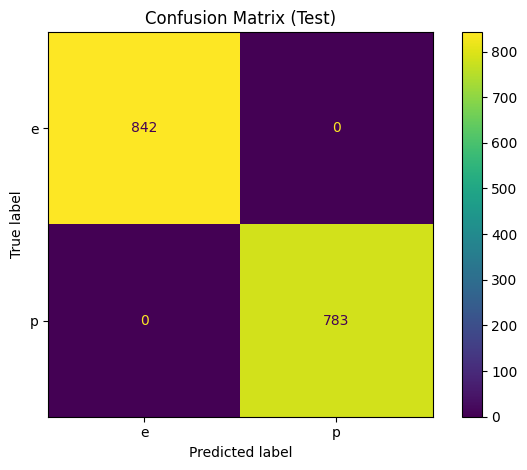

In [27]:
# --------------------------------------------
# 7) Evaluate on held-out TEST
# --------------------------------------------
# Use the best KNN model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test_enc)  # 1 line

# accuracy
test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy: {:.4f}".format(test_acc))

#  classification
print("\nClassification report:\n", classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


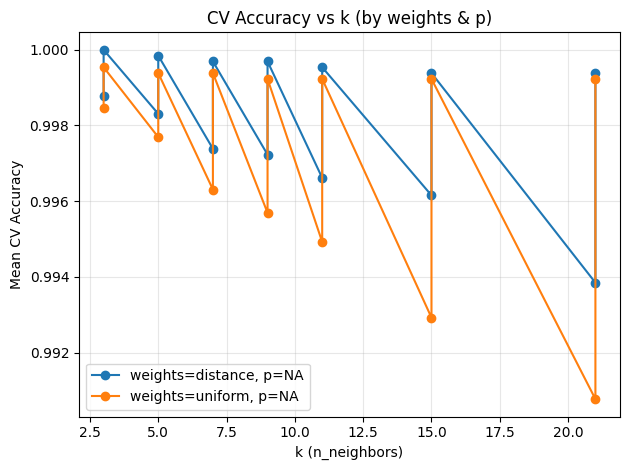

In [31]:
# --------------------------------------------
# 8) Validation curve (CV accuracy vs k)
# --------------------------------------------
cvres = pd.DataFrame(grid_search.cv_results_) 

if "param_p" in cvres.columns:
    plotdf = cvres[["param_n_neighbors", "param_weights", "param_p", "mean_test_score"]].rename(
        columns={"param_n_neighbors":"k", "param_weights":"weights", "param_p":"p"}
    )
else:
    plotdf = cvres[["param_n_neighbors", "param_weights", "mean_test_score"]].rename(
        columns={"param_n_neighbors":"k", "param_weights":"weights"}
    )
    plotdf["p"] = "NA" 

plt.figure()
for (w, pval), sub in plotdf.groupby(["weights", "p"]):
    sub = sub.sort_values("k")
    plt.plot(sub["k"], sub["mean_test_score"], marker="o", label=f"weights={w}, p={pval}")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.title("CV Accuracy vs k (by weights & p)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


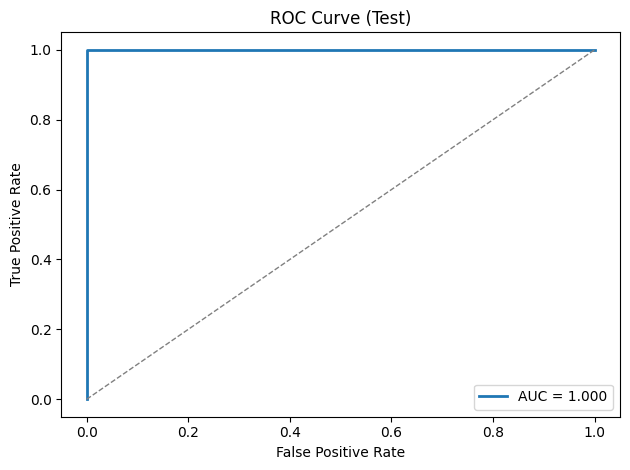

In [32]:
# --------------------------------------------
# 9) ROC curve (binary; micro-average if multiclass)
# --------------------------------------------
best_knn = grid_search.best_estimator_

if hasattr(best_knn, "predict_proba"):
    classes_ = np.unique(y_train)
    y_test_enc_int = pd.Categorical(y_test, categories=classes_).codes
    proba = best_knn.predict_proba(X_test_enc)

    if len(classes_) == 2:
        fpr, tpr, _ = roc_curve(y_test_enc_int, proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], lw=1, linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Test)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    else:
        y_bin = label_binarize(y_test_enc_int, classes=range(len(classes_)))
        fpr, tpr, _ = roc_curve(y_bin.ravel(), proba.ravel())
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"Micro-average AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], lw=1, linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Micro-average)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()


In [33]:
# --------------------------------------------
# 10) Print summary of features
# Sample Output: Final feature count: 25
# Best KNN: KNeighborsClassifier(n_neighbors=7, p=2, weights='distance')
# --------------------------------------------
# TODO: Print the final stats (2 lines of code)

print("Final feature count:", X_train_enc.shape[1])
print("Best KNN:", grid_search.best_estimator_)


Final feature count: 22
Best KNN: KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
